## This notebook explains how we can go about explore and prepare data for model building.The notebook is structured in the following way

About Dataset

Data Summary

Feature Engineering

Missing Value Analysis

Outlier Analysis

Correlation Analysis

Visualizing Distribution Of Data

Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)

Filling 0's In Windspeed Using Random Forest

Linear Regression Model

Regularization Models

Ensemble Models

## About Dataset

Overview
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.



In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

Lets Read In The Dataset

In [2]:
dailyData = pd.read_csv("train.csv") #reading file to pandas dataframe

Data Summary
As a first step lets do three simple steps on the dataset

Size of the dataset
Get a glimpse of data by printing few rows of it.
What type of variables contribute our data


Shape Of The Dataset

In [3]:
dailyData.shape

(10886, 12)

Sample Of First Few Rows

In [4]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### Data Fields- Information about each attribute

**datetime** - hourly date + timestamp (every hour)

**season** - 

    1 = spring,
    2 = summer, 
    3 = fall,
    4 = winter

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather -**

    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals (Dependent Variable

In [5]:
#Variables Data Type
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

#### Feature Engineering:


As we see from the above results, the columns "season", "holiday", "workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

Create new columns "date,"hour","weekDay","month" from "datetime" column.
Coerce the datatype of "season","holiday","workingday" and weather to category.
Drop the datetime column as we already extracted useful features from it.
Creating New Columns From "Datetime" Column

In [6]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0]) #splitting every record and taking only the 
#first index which consists of date
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0]) #splitting every record and taking
#only hour the x.split()[1] gives hour:minute:second and the .split(":")[0] gives only hour
#so first break the data into date and time and then select only time
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
#this is to select on which weeday is that date falling for every record in date column we are taking the date and saying its format
#is in Y-M-D and hence it will compare with the calendar and gives us the weekday as output

dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
#this will give th month of the date

dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
#we are changing the numbers 1,2,3,4 in season column to their respective season in words



dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })
#changing the numeric to word format

#### Coercing To Category Type

In [7]:
#changing all these attributes to category type
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
#creating a list of names which we need to change to category type and storing in categoryVariableList
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")
#creating a for loop to iterate over each name in list and change the type tp category

#### Dropping Unncessary Columns

In [8]:
dailyData  = dailyData.drop(["datetime"],axis=1)

#### Lets Start With Very Simple Visualization Of Variables DataType Count

In [9]:
dailyData.dtypes.value_counts().reset_index()

,index,0
0,int64,4
1,float64,3
2,category,2
3,category,1
4,category,1
5,category,1
6,object,1
7,category,1
8,category,1


C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

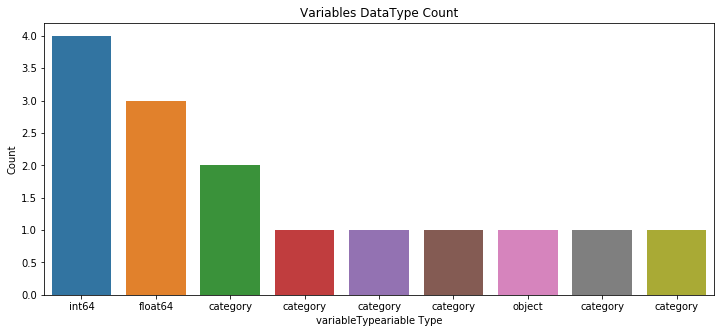

In [10]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
#first the dtypes gives the variable type as output and next value_counts gives the sum of each type of attribute
#by resetting index the type of the attribute will be added as new column and the names of the columns are changed from index to 
#variabletype and from 0 to count


fig,ax = plt.subplots()
#these are pre-definations for plot fig is defined to change 

fig.set_size_inches(12,5)
#this is the dimensions of the plot

sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
#to create a bar type of plot where x axis is variable type and y axis is count and dataframe is dataTypeDF

ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")
#create the names for axis 

#### Missing Values Analysis
Once we get hang of the data and columns, next step we geneally is to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

Skewness In Distribution

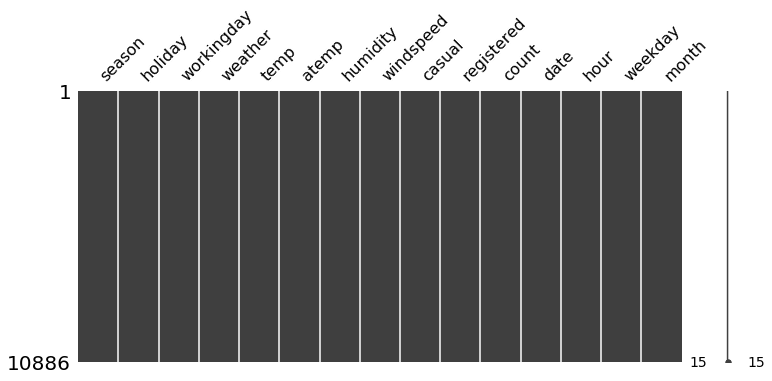

In [11]:
msno.matrix(dailyData,figsize=(12,5))

#### Outliers Analysis
At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.
The boxplot with "Hour Of The Day" is quiet interesting.The median value are relatively higher at 7AM - 8AM and 5PM - 6PM. It can be attributed to regular school and office users at that time.
Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day". It is quiet visible from from figure 4.

C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

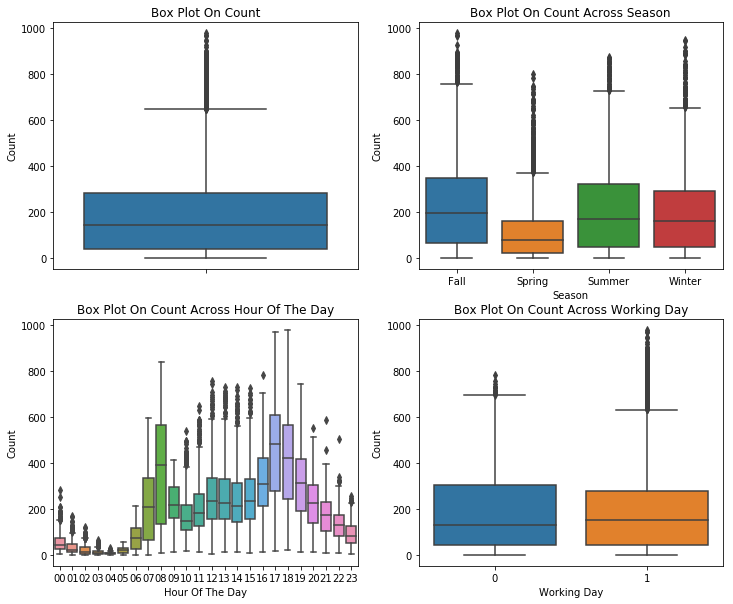

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
#number of figures to plot in one cell. This plots 4 figures two on x-axis

fig.set_size_inches(12, 10)
#dimensions of each plot

sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0]) #to plot boxplot of count column
#orient is the type of orientation 'v' represents vertical 
#ax is the object which is called for additional details in plotting and its position in the plot

sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
 #to boxplot season on x-axis and count on y-axis
    
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
#to boxplot hour on x-axis and count on y-axis

sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])
#to boxplot working day on x-axis and count on y-axis

axes[0][0].set(ylabel='Count',title="Box Plot On Count") #details for axes[0][0]
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season") #details for axes[0][1]
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day") #details for axes[1][0]
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")#details for axes[1][1]

#### Lets Remove Outliers In The Count Column

In [13]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 
#substracting every data point in count column with the mean of the count column and then doing np.abs which will 
#create absolute values 
#now comparing this value with 3 times of standard deviation of the column and preserving only those records which are 
#less than 3*dailyData["count"].std()

In [14]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


#### Correlation Analysis
One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

temp and humidity features has got positive and negative correlation with count respectively.Although the correlation between them are not very prominent still the count variable has got little dependency on "temp" and "humidity".
windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
"atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
"Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.
Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

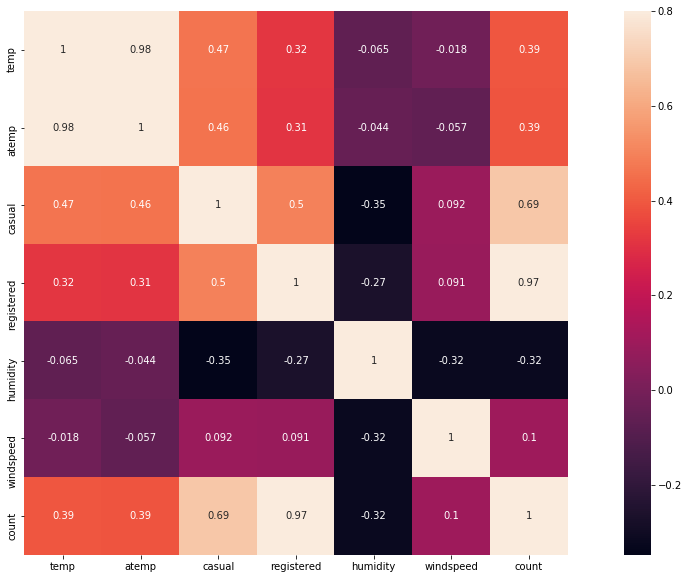

In [15]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
#for corelation we have to change the data into new format 
#select the attributes (only numerical attributes) and add .corr() at its end

#mask = np.array(corrMatt)
#this will create corelation valu

#mask[np.tril_indices_from(mask)] = False


fig,ax= plt.subplots() #create dimensions for the plot and axes for multiple plots or for additional details


fig.set_size_inches(20,10)#setting size

sn.heatmap(corrMatt,vmax=.8, square=True,annot=True) #heatmap code
#mask removes the right to diagonal data in the figure
#vmax is the maximum value in the range i.e the 0.8 in right bar
#square=True is used for shape
#annot is used to give the values inside the square box 

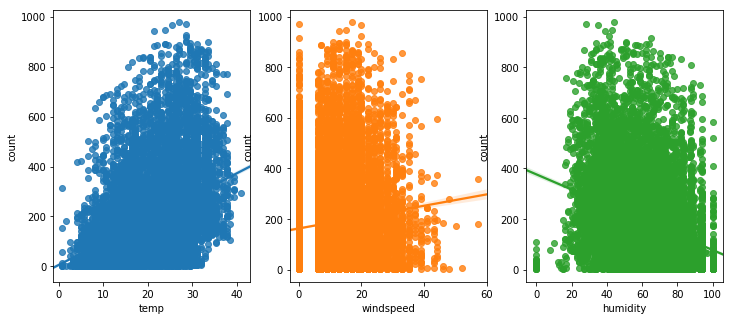

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3) 
#fig for dimensions 
#ax1,ax2,ax3 are for the number of figures to plot

fig.set_size_inches(12, 5)
#setting size of figure

sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
#regplot draws linear line with the data points
#generate regplot with temp on x-axis and count on y-axis and plot it on axis 1

sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
#generate regplot with windspeed on x-axis and count on y-axis and plot it on axis 2

sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)
#generate regplot with humidity on x-axis and count on y-axis and plot it on axis 3


#### Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096116))

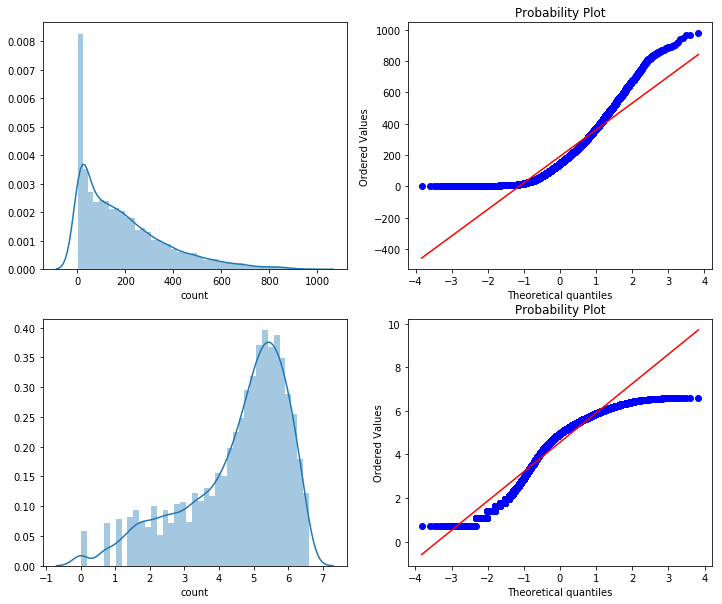

In [17]:
fig,axes = plt.subplots(ncols=2,nrows=2) 
#create fig for dimensions
#axes four with 2 columns and 2 rows


fig.set_size_inches(12, 10)
#dimensions

sn.distplot(dailyData["count"],ax=axes[0][0])
#create a distribution plot of count column and on first axes

stats.probplot(dailyData["count"], dist='norm', plot=axes[0][1])
#create q-q plot with normal distribution

sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
#create a distribution plot of logarithm of count column and on first axes


stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])
#create q-q plot with log of count column


#### Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

Visualizing Count Vs (Month,Season,Hour,Weekday,Usertype)
It is quiet obvious that people tend to rent bike during summer season since it is really conducive to ride bike at that season.Therefore June, July and August has got relatively higher demand for bicycle.
On weekdays more people tend to rent bicycle around 7AM-8AM and 5PM-6PM. As we mentioned earlier this can be attributed to regular school and office commuters.
Above pattern is not observed on "Saturday" and "Sunday".More people tend to rent bicycle between 10AM and 4PM.
The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.

C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

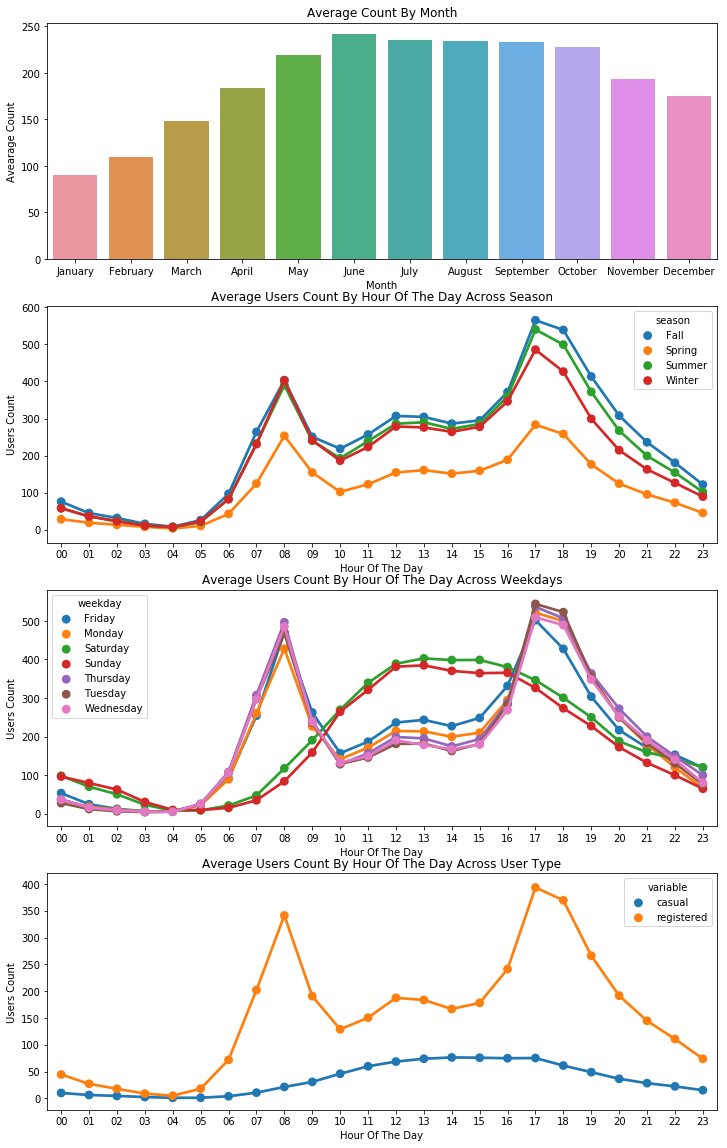

In [18]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
#define four plots in this cell which have to be placed in one below another

fig.set_size_inches(12,20)
#setting figure size

sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
#creating a list to print the plot according to this sequence

hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
#creating a list to print the plot according to this sequence


monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
#aggregating the data by first taking count attribute and grouping it by month and next 
#taking the mean of every month and storing it in new attribute
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
#sorting the monthAggregated dataframe in descending order
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
#plotting with month on x-axis and count on y-axis and naming it as first plot in the sequence
#the output is going to start from jan and end in december while using order
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")
#naming axis and plot

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"])["count"].mean()).reset_index()
#aggregating the data by first grouping the data by hour and then by season
#taking the mean of every every hour of every season and then resetting it to create dataframe
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated,ax=ax2)
#plot with hour on x-axis and count on y-axis and season as hue i.e color and plot in second position
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')
#naming the plot

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"])["count"].mean()).reset_index()
#creating hour aggragation by grouping the count attribute by hour and then by weekday and
#the value of count is the mean of every hour of every weekday
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"], data=hourAggregated,ax=ax3)
#plotting with hour on x-axis and count on y-axis with weekday as legend third plot in the sequence
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')
#naming the plot

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
#this code is going to create three attributes in which hour attribute is the base
#the other two attributes are type of ride(casual and registered) and count
#one will get the count of casual users at different hours and also the count of registered users at different hours
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
#this is going to group hourtransformed by hour and variable and then replace value by mean of the value of hour and type of user
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated,ax=ax4)
#plot hour on x-axis and value on y-axis with variable (type of users) as legend and plot it fourth position
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')
#naming the plot

So we have visualized the data to a greater extent.So lets go and build some models and see how close we can predict the results.

Filling 0's In windspeed Using Random Forest
Lets Read In Train And Test Data

In [19]:
dataTrain = pd.read_csv("train.csv") #importing the data
dataTest = pd.read_csv("test.csv")

#### Combine Train And Test

In [20]:
data = dataTrain.append(dataTest) #adding test data below train data
data.reset_index(inplace=True) #resetting index
data.drop('index',inplace=True,axis=1) #droping the index

#### Feature Engineering

In [21]:
data["date"] = data.datetime.apply(lambda x : x.split()[0]) #splitting every record and taking only the 
#first index which consists of date

data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int") #splitting every record and taking
#only hour the x.split()[1] gives hour:minute:second and the .split(":")[0] gives only hour
#so first break the data into date and time and then select only time

data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])

data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
#this is to select on which weeday is that date falling for every record in date column we are taking the date and saying its format
#is in Y-M-D and hence it will compare with the calendar and gives us the weekday as output

data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
#this will give th month of the date



#### Random Forest Model To Predict 0's In Windspeed


In [22]:
data.isnull().sum() #number of NA values in each attribute

atemp            0
casual        6493
count         6493
datetime         0
holiday          0
humidity         0
registered    6493
season           0
temp             0
weather          0
windspeed        0
workingday       0
date             0
hour             0
year             0
weekday          0
month            0
dtype: int64

In [23]:
(data == 0).astype(int).sum(axis=0) #number of records having zero for each coulmn

atemp             2
casual          986
count             0
datetime          0
holiday       16879
humidity         22
registered       15
season            0
temp              0
weather           0
windspeed      2180
workingday     5514
date              0
hour            726
year              0
weekday        2479
month             0
dtype: int64

In [24]:
from sklearn.ensemble import RandomForestRegressor #importing random forest regressor

dataWind0 = data[data["windspeed"]==0]
#getting the attributes whose windspeed is equal to zero

dataWindNot0 = data[data["windspeed"]!=0]
#saving data whose windspeed is not equal to zero

rfModel_wind = RandomForestRegressor()
#initiating the model

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
#creating a list of column names which we think are dependant for predicting windspeed

rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
#fitting the model on data which has windspeed more than 1  and choosing attributes given in the above list

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
#rndom forest is going to predict on the data where windspeed is zero 


dataWind0["windspeed"] = wind0Values
#creating attribute with rf predicted values

data = dataWindNot0.append(dataWind0)
#adding the records of wind data and predicted wind data into new dataframe data


data.reset_index(inplace=True,drop=True)#resetting the index to make sure everything starts from zero

### Coercing To Categorical Type

In [25]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
#creating a list of categorical names 
#we have to convert the categorical attributes either to dummy or can change the type to category
#where model will recognize that the attribute is categorical

numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
#these are the numerical attributes

dropFeatures = ['casual',"count","datetime","date","registered"]
#we no longer need these attributes for building the model

In [26]:
#convert the attributes listed above to categorical form
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

### Splitting Train And Test Data

In [27]:
data.isnull().sum()

atemp            0
casual        6493
count         6493
datetime         0
holiday          0
humidity         0
registered    6493
season           0
temp             0
weather          0
windspeed        0
workingday       0
date             0
hour             0
year             0
weekday          0
month            0
dtype: int64

In [28]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
#taking the non-zero values of count attribute and sorting by time for training the data

dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
#taking the zero values of count attribute and sorting by time for testing the data

datetimecol = dataTest["datetime"]
#creating attribute of dataetimcol

yLabels = dataTrain["count"]
#the output we have to find is count so taking that as Y

yLablesRegistered = dataTrain["registered"]
#y as registered

yLablesCasual = dataTrain["casual"]
#y as casual

#### Dropping Unncessary Variables

In [29]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1) #removing the unnecessary attributes
dataTest  = dataTest.drop(dropFeatures,axis=1) #removing the unnecessary attributes

### RMSLE Scorer

In [32]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Linear Regression Model

In [33]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize linear regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels) #as the disribution is not normal we did log(y) and we are taking that as Y
lModel.fit(X = dataTrain,y = yLabelsLog) #fitting the model with X and Y

# Make predictions
preds = lModel.predict(X= dataTrain) #predicting the model on test data
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.977982626661


##### Regularization Model - Ridge

Regularization Model - Ridge

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.977982611562


C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


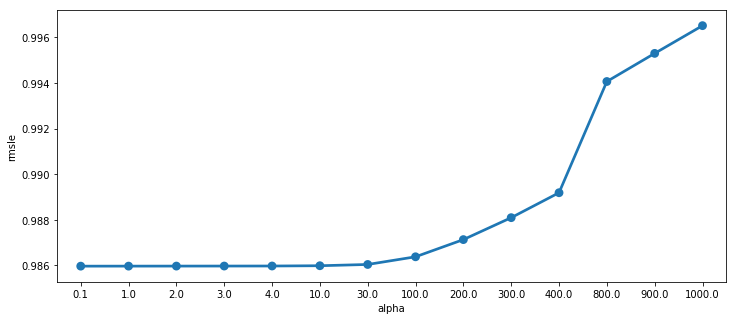

In [36]:
ridge_m_ = Ridge() #initialting ridge regression
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
#these is list of tuning parameters
#max_iter is number of iterations to run the regression

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# which error to focus on 

grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
#grid search is used to find the best parameters where the model performs excellent
#here the model is ridge_m
#the parameters are ridge_params
#scoring is based on rmsle_scorer
#we are using k-fold testing and it is 5

yLabelsLog = np.log1p(yLabels)
#the y-axis

grid_ridge_m.fit( dataTrain, yLabelsLog )
#fitting the model with x and y


preds = grid_ridge_m.predict(X= dataTrain)
#predicting the test data with ridge model

print (grid_ridge_m.best_params_) #the best parameters for which the regression achieves minimum error is printed

print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))
#the error from ridge

fig,ax= plt.subplots()
#define plot
fig.set_size_inches(12,5)
#set plot size
df = pd.DataFrame(grid_ridge_m.grid_scores_)
#create dataframe from grid_scores which stores the error for different values of alpha and iterations

df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#creating alpha attribute and extracting alpha values from parameters

df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
#creating rmsle attribute and getting the error value from mean_validation_score attribute
#please check df dataframe for clear idea
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)
#plotting the graph

#### Regularization Model - Lasso

{'alpha': 0.0050000000000000001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.978120126625


C:\Users\mohad\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


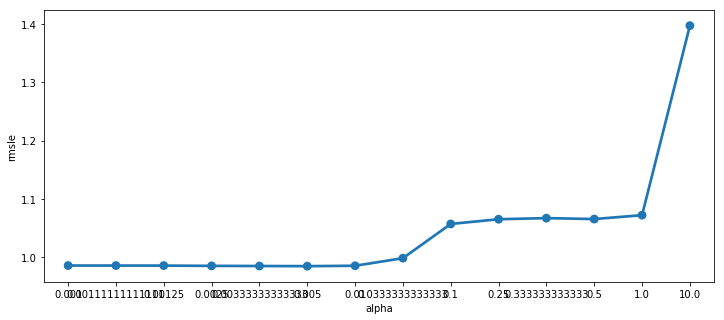

In [40]:


lasso_m_ = Lasso()#initialting lasso regression

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]) #giving different values of alpha


lasso_params_ = { 'max_iter':[3000],'alpha':alpha} 
#these is list of tuning parameters
#max_iter is number of iterations to run the regression

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
#grid search is used to find the best parameters where the model performs excellent
#here the model is grid_lasso_m
#the parameters are lasso_params
#scoring is based on rmsle_scorer
#we are using k-fold testing and it is 5

yLabelsLog = np.log1p(yLabels)
#the y-axis
grid_lasso_m.fit( dataTrain, yLabelsLog )
#fitting the model with x and y
preds = grid_lasso_m.predict(X= dataTrain)
#predicting the test data with ridge model
print (grid_lasso_m.best_params_)
#best parameters for which the model acheives minimum error is printed
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))
#the error from lasso

fig,ax= plt.subplots()
#define plot
fig.set_size_inches(12,5)
#set plot size
df = pd.DataFrame(grid_lasso_m.grid_scores_)
#create dataframe from grid_scores which stores the error for different values of alpha and iterations
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#creating alpha attribute and extracting alpha values from parameters
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
#creating rmsle attribute and getting the error value from mean_validation_score attribute
#please check df dataframe for clear idea
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)
#plotting the graph

##### Ensemble Models - Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor #importing random forest regressor
rfModel = RandomForestRegressor(n_estimators=100) 
#initializing the model and creating 100 trees
#i.e 100 boot sampling 

yLabelsLog = np.log1p(yLabels)
#y-axis

rfModel.fit(dataTrain,yLabelsLog)
#fitting the model to train data

preds = rfModel.predict(X= dataTrain)
#predicting on test data

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))
#printing the error made by model

RMSLE Value For Random Forest:  0.102473899025


#### Ensemble Model - Gradient Boost

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
#initiating the gradient boosting with 4000 iterations and learning rate=0.01

yLabelsLog = np.log1p(yLabels)
#y-axis

gbm.fit(dataTrain,yLabelsLog)
#fittinng the model

preds = gbm.predict(X= dataTrain)
#predicting 

print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))
#printing the error

RMSLE Value For Gradient Boost:  0.190238642391


Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.

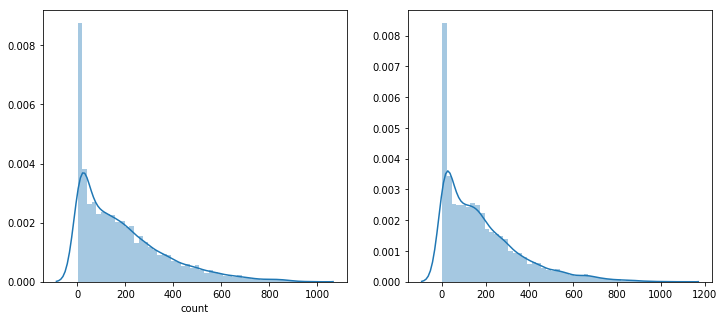

In [87]:
predsTest = gbm.predict(X= dataTest)
#predicting on test data using GBM

fig,(ax1,ax2)= plt.subplots(ncols=2)
#plotting two figures

fig.set_size_inches(12,5)
#dimensions of each figure

sn.distplot(yLabels,ax=ax1,bins=50)
#plotting the original test data on axis 1

sn.distplot(np.exp(predsTest),ax=ax2,bins=50)
#plotting predicted values of GBM

In [88]:
#creating dataframe with two columns
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })

#first datetime where the values are taken from datetime
#the count of prediction by GBM

submission.to_csv('bike_predictions_gbm_separate_without_fe.csv', index=False)
#exporting it to excel file